# Desafio 03 - Modelo de lenguaje con tokenizacion - Word

In [1]:
from tensorflow.keras.utils import pad_sequences # se utilizará para padding
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, TimeDistributed, CategoryEncoding, SimpleRNN, Dense, GRU
from keras.models import Model, Sequential

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
from tensorflow.keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
# Verifica si TensorFlow está utilizando GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Verifica los dispositivos disponibles y sus detalles
for device in tf.config.list_physical_devices():
    print(device)

Num GPUs Available:  1
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


Para el desafío se utilizo el libro "veinte mil leguas de viaje submarino" de Julio Verne

In [3]:
# Leer el archivo de texto
with open('libro_utilizado.txt', 'r', encoding='utf-8') as file:
    text = file.read()

## Utilizando palabras

In [4]:
import nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence # equivalente a word_teokenize de nltk
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Separar el texto en oraciones
sentences = sent_tokenize(text)

In [6]:
#quedarme con la mitad del texto para reducir el vocabulario y por cuestiones prácticas del desafío
sentences = sentences[:len(sentences)//2]

In [7]:
print("Cantidad de documentos:", len(sentences))
sentences[0:2]

Cantidad de documentos: 4308


['Primera parte\n1.',
 'Un escollo fugaz\nEl año 1866 quedó caracterizado por un extraño acontecimiento, por un fenómeno inexplicable e inexplicado que nadie, sin duda, ha podido olvidar.']

In [8]:
sentence_tokens = [text_to_word_sequence(sentence) for sentence in sentences]
print("Cantidad de tokens:", len(sentence_tokens))

Cantidad de tokens: 4308


In [9]:
sentence_tokens[0:2]

[['primera', 'parte', '1'],
 ['un',
  'escollo',
  'fugaz',
  'el',
  'año',
  '1866',
  'quedó',
  'caracterizado',
  'por',
  'un',
  'extraño',
  'acontecimiento',
  'por',
  'un',
  'fenómeno',
  'inexplicable',
  'e',
  'inexplicado',
  'que',
  'nadie',
  'sin',
  'duda',
  'ha',
  'podido',
  'olvidar']]

In [10]:
length_sentences = [len(sentence) for sentence in sentence_tokens]

(array([751., 787., 944., 668., 482., 241., 189.,  98.,  53.,  39.,  12.,
         12.,   7.,   6.,   2.,   6.,   2.,   1.,   0.,   2.,   1.,   0.,
          1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   1.]),
 array([  0.  ,   5.44,  10.88,  16.32,  21.76,  27.2 ,  32.64,  38.08,
         43.52,  48.96,  54.4 ,  59.84,  65.28,  70.72,  76.16,  81.6 ,
         87.04,  92.48,  97.92, 103.36, 108.8 , 114.24, 119.68, 125.12,
        130.56, 136.  , 141.44, 146.88, 152.32, 157.76, 163.2 , 168.64,
        174.08, 179.52, 184.96, 190.4 , 195.84, 201.28, 206.72, 212.16,
        217.6 , 223.04, 228.48, 233.92, 239.36, 244.8 , 250.24, 255.68,
        261.12, 266.56, 272.  ]),
 <BarContainer object of 50 artists>)

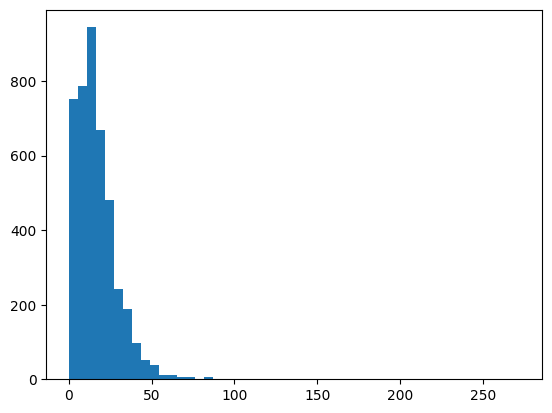

In [11]:

# podemos ver su distribución
plt.hist(length_sentences,bins=50)

In [12]:
# el -1 es porque el último token será el target
max_context_size = int(np.percentile(length_sentences, 90)-1)

print(f'max_context_size: {max_context_size}')

# instanciamos el tokenizador
tok = Tokenizer()
tok.fit_on_texts(sentence_tokens)
tokenized_sentences = tok.texts_to_sequences(sentence_tokens)

max_context_size: 32


In [13]:
tokenized_sentences[0]

[384, 89, 1750]

In [14]:
sentence_tokens[0]

['primera', 'parte', '1']

In [15]:
tokenized_sentences_train, tokenized_sentences_val, _, _ = train_test_split(tokenized_sentences, sentence_tokens, test_size=0.2, random_state=42)

In [16]:
#print de tamaña de dataset de entrenamiento y validacion
print(f'tokenized_sentences_train: {len(tokenized_sentences_train)}')
print(f'tokenized_sentences_val: {len(tokenized_sentences_val)}')

tokenized_sentences_train: 3446
tokenized_sentences_val: 862


In [17]:
tok_sent = []

for sent in tokenized_sentences_train:

  # si la secuencia tiene más términos que el tamaño de contexto máximo,
  # armo varias sub-secuencias de tamaño máximo
  if len(sent) > (max_context_size+1):
    extra = len(sent)-(max_context_size+1) + 1
    for i in range(extra):
      tok_sent.append(sent[i:i+max_context_size+1])
  else: # si la secuencia tiene menos términos el tamaño de contexto máximo, dejo la secuencia como está
    tok_sent.append(sent)

In [18]:
len(tok_sent)

7568

In [19]:
tok_sent_augm = []

for sent in tok_sent:

  # generamos todas las sub-secuencias
  subseq = [sent[:i+2] for i in range(len(sent)-1)]
  # en esta línea paddeamos al tamaño de contexto máximo
  tok_sent_augm.append(pad_sequences(subseq, maxlen=max_context_size+1, padding='pre'))

In [20]:
# finalmente concatenamos todas las secuencias en un único array de numpy
train_seqs = np.concatenate(tok_sent_augm, axis=0)

In [21]:
train_seqs.shape

(181920, 33)

In [22]:
# y de aquí sacamos las entradas y los targets que consumirá nuestro sistema en
# tiempo de entrenamiento
X = train_seqs[:,:-1]
y = train_seqs[:,1:]

In [23]:
# Cantidad de palabras en el vocabulario
vocab_size = len(tok.word_counts)
vocab_size

11683

In [24]:
print(tok.word_docs)

defaultdict(<class 'int'>, {'parte': 69, '1': 4, 'primera': 19, 'ha': 112, 'un': 731, 'caracterizado': 1, 'acontecimiento': 3, '1866': 2, 'inexplicado': 1, 'escollo': 11, 'nadie': 14, 'por': 658, 'quedó': 8, 'fenómeno': 15, 'sin': 196, 'fugaz': 4, 'extraño': 16, 'duda': 26, 'podido': 31, 'que': 1547, 'olvidar': 4, 'año': 12, 'e': 29, 'inexplicable': 9, 'el': 1553, 'habitantes': 7, 'poblaciones': 2, 'mar': 154, 'misterioso': 3, 'los': 820, 'continentes': 19, 'a': 1294, 'una': 705, 'de': 2104, 'sobreexcitaban': 1, 'y': 1345, 'puertos': 1, 'del': 757, 'las': 688, 'interior': 30, 'suscitó': 1, 'rumores': 1, 'entre': 112, 'emoción': 13, 'particular': 15, 'agitaban': 1, 'hablar': 17, 'hombres': 42, 'preocupación': 3, 'todos': 70, 'armadores': 1, 'países': 6, 'la': 1482, 'tras': 59, 'europa': 14, 'diferentes': 18, 'capitanes': 2, 'américa': 14, 'mayor': 37, 'estados': 5, 'guerra': 6, 'manifestaron': 1, 'masters': 1, 'barco': 67, 'negociantes': 1, 'dos': 167, 'skippers': 1, 'gobiernos': 3, 'ma

In [25]:
print(tok.index_word)

{1: 'de', 2: 'la', 3: 'el', 4: 'que', 5: 'y', 6: 'a', 7: 'en', 8: 'los', 9: 'se', 10: 'del', 11: 'las', 12: 'un', 13: 'una', 14: 'por', 15: 'no', 16: 'su', 17: 'con', 18: 'al', 19: 'me', 20: 'más', 21: 'sus', 22: 'es', 23: 'pero', 24: 'lo', 25: 'para', 26: 'capitán', 27: 'como', 28: 'había', 29: 'yo', 30: 'ned', 31: 'nautilus', 32: 'señor', 33: 'mi', 34: 'sin', 35: 'conseil', 36: 'era', 37: 'nemo', 38: 'usted', 39: 'dos', 40: 'nos', 41: 'si', 42: 'le', 43: 'mar', 44: 'muy', 45: 'ya', 46: 'o', 47: 'land', 48: 'sobre', 49: 'este', 50: 'agua', 51: 'tan', 52: 'pues', 53: 'ha', 54: 'entre', 55: 'ese', 56: 'ni', 57: 'así', 58: 'mis', 59: 'cuando', 60: 'hacia', 61: 'hasta', 62: 'mil', 63: 'vez', 64: 'él', 65: '—dijo', 66: 'ser', 67: 'esa', 68: 'todo', 69: 'algunos', 70: 'metros', 71: 'durante', 72: 'esta', 73: 'bordo', 74: 'bien', 75: 'medio', 76: 'unos', 77: 'superficie', 78: 'son', 79: 'profesor', 80: 'tres', 81: 'poco', 82: 'bajo', 83: 'tiempo', 84: 'océano', 85: 'comandante', 86: 'hombre'

### Funciones a utilizar

Se realizaron modificaciones en la función de callback para disminuir el consumo de vRAM utilizado. Entre los principales cambios esta el manejor por batches del dataset de validación o la eliminación de resultados temporales.

In [26]:
import numpy as np
from keras.callbacks import Callback
from keras.preprocessing.sequence import pad_sequences

class MemoryEfficientPplCallback(Callback):
    """
    Callback personalizado para calcular la perplejidad sobre un conjunto de validación al final de cada epoch,
    minimizando el uso de memoria mediante procesamiento por lotes (batching).
    Implementa Early Stopping si la perplejidad no mejora después de `patience` epochs.
    """

    def __init__(self, val_data, max_context_size, history_ppl, model_name='my_model.keras', patience=5, batch_size=32):
        super().__init__()
        self.val_data = val_data
        self.max_context_size = max_context_size
        self.history_ppl = history_ppl
        self.model_name = model_name
        self.patience = patience
        self.batch_size = batch_size

        # Inicialización de datos de validación
        self.target = []
        self.padded = []
        self.info = []

        count = 0
        for seq in self.val_data:
            len_seq = len(seq)
            # Crear subsecuencias
            subseq = [seq[:i] for i in range(len_seq)]
            self.target.extend([seq[i] for i in range(len_seq)])

            if len(subseq) != 0:
                self.padded.append(pad_sequences(subseq, maxlen=self.max_context_size, padding='pre'))
                self.info.append((count, count + len_seq))
                count += len_seq

        # Convertir a numpy arrays
        self.padded = np.vstack(self.padded)
        self.min_score = np.inf
        self.patience_counter = 0

    def on_epoch_end(self, epoch, logs=None):
        # Lista para almacenar los scores de perplejidad
        scores = []

        # Iterar sobre los índices de inicio y fin de las secuencias en info
        for start_idx, (start, end) in enumerate(self.info):
            batch_padded = self.padded[start:end]
            num_batches = int(np.ceil(len(batch_padded) / self.batch_size))

            probs = []
            # Procesar en lotes pequeños para reducir el uso de memoria
            for i in range(num_batches):
                batch_start = i * self.batch_size
                batch_end = min((i + 1) * self.batch_size, len(batch_padded))
                batch_predictions = self.model.predict(batch_padded[batch_start:batch_end], verbose=0)

                # Extraer las probabilidades correspondientes
                for idx_seq, idx_vocab in zip(range(batch_start, batch_end), self.target[start:end]):
                    probs.append(batch_predictions[idx_seq - batch_start, -1, idx_vocab])

            # Calcular la perplejidad de la secuencia actual
            scores.append(np.exp(-np.sum(np.log(probs)) / (end - start)))

            # Limpiar memoria después de cada secuencia
            del batch_padded, batch_predictions, probs

        # Promediar las perplejidades de todas las secuencias
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_name)
          print(f"Saved new model! How {self.model_name}")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True

Se incorporo la opción de poder utilizar multiples modelos en la funciones que busca la respuesta del modelo

In [27]:
def model_response(human_text, model_name):
    """
    Esta función recibe el texto de entrada del usuario y el nombre del modelo a utilizar.
    Genera una respuesta utilizando el modelo seleccionado.
    """

    models = {
        "SimpleRNN": model_RNN,
        "LSTM": model_LSTM,
        "GRU": model_GRU,
    }

    model = models[model_name]

    # Encodeamos
    encoded = tok.texts_to_sequences([human_text])[0]
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=max_context_size, padding='pre')

    # Predicción softmax
    y_hat = np.argmax(model.predict(encoded)[0,-1,:])


    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in tok.word_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha
    return human_text + ' ' + out_word

In [28]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	  # generate a fixed number of words
    for _ in range(n_words):
		  # Tokenizamos
      encoded = tokenizer.texts_to_sequences([output_text])[0]

		  # Si tienen distinto largo
      encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

		  # Predicción softmax
      y_hat = np.argmax(model.predict(encoded)[0,-1,:])

      # Vamos concatenando las predicciones
      out_word = ''

      # Debemos buscar en el vocabulario la palabra
      # que corresopnde al indice (y_hat) predicho por le modelo
      for word, index in tokenizer.word_index.items():
        if index == y_hat:
          out_word = word
          break

		  # Agrego las palabras a la frase predicha
      output_text += ' ' + out_word

    return output_text

In [29]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=max_context_size):

    encoded = tok.texts_to_sequences([text])[0]
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    return tok.sequences_to_texts([seq])

In [30]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp,mode):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if mode == 'det':
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  elif mode == 'sto':
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo aleatorio
  else:
    raise ValueError(f'Wrong selection mode. {mode} was given. det and sto are supported.')

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1,mode='det'):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = model.predict(encoded,verbose=0)[0,-1,:]

    # get vocabulary size
    vocab_size = y_hat.shape[0]

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp,
                                        mode)

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = model.predict(input_update,verbose=0)[0,-1,:]

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp,
                                                        mode)

    return history_tokens

### MODELOS

#### LSTM

Al modelo base propuesto en el enunciado, se le agregaron capas de dropout y una capa densa en busqueda de un mejor resultado.

In [31]:
model_LSTM = Sequential()
model_LSTM.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(100, return_sequences=True))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(50, activation='relu'))
model_LSTM.add(Dense(vocab_size+1, activation='softmax'))
model_LSTM.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model_LSTM.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 50)            │         584,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, None, 100)           │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, None, 100)           │          80,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, None, 50)            │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 11684)         │         595,884 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,325,934 (5.06 MB)

 Trainable params: 1,325,934 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

#### SimpleRNN

Con el objetivo de probar diferentes arquitecturas, se utilizo simpleRNN con una única capa de dropout

In [32]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model_RNN.add(SimpleRNN(100, return_sequences=True))
model_RNN.add(Dropout(0.5))
model_RNN.add(SimpleRNN(100, return_sequences=True))
model_RNN.add(Dense(vocab_size+1, activation='softmax'))
model_RNN.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model_RNN.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 50)            │         584,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, None, 100)           │          15,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, None, 100)           │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, None, 11684)         │       1,180,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,799,484 (6.86 MB)

 Trainable params: 1,799,484 (6.86 MB)

 Non-trainable params: 0 (0.00 B)

#### GRU

Por otro lado, tambien se implemento un modelo GRU.

In [61]:
model_GRU = Sequential()

model_GRU.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_shape=(None,)))
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(Dropout(0.5))
model_GRU.add(GRU(100, return_sequences=True))
model_GRU.add(Dense(vocab_size+1, activation='softmax'))
model_GRU.compile(loss=SparseCategoricalCrossentropy(), optimizer='rmsprop')
model_GRU.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ (None, None, 50)            │         584,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, None, 100)           │          45,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, None, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_8 (GRU)                          │ (None, None, 100)           │          60,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, None, 11684)         │       1,180,084 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,870,484 (7.14 MB)

 Trainable params: 1,870,484 (7.14 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamientos

In [34]:
history_ppl_LSTM = []

# Callback actualizado con el nuevo `MemoryEfficientPplCallback`
ppl_callback = MemoryEfficientPplCallback(
    val_data=tokenized_sentences_val,   # Datos de validación (secuencias tokenizadas)
    max_context_size=max_context_size,  # Tamaño máximo de la secuencia (ajustar según el contexto de tu tarea)
    history_ppl=history_ppl_LSTM,       # Historia de la perplejidad
    model_name='model_LSTM_word.keras',      # Nombre del modelo a guardar cuando la perplejidad mejore
    patience=5,                         # Número de épocas de paciencia para el early stopping
    batch_size=256                      # Tamaño de lote para el procesamiento por lotes
)

# Entrenar el modelo con el callback optimizado
hist = model_LSTM.fit(
    X, y,                               # Datos de entrenamiento
    epochs=20,                          # Número de épocas
    batch_size=256,                      # Tamaño de lote para el entrenamiento
    callbacks=[ppl_callback]            # El nuevo callback optimizado
)

Epoch 1/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 4.2120
 mean perplexity: 656532.6871408483 

Saved new model! How model_LSTM.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 121s 151ms/step - loss: 4.2102
Epoch 2/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 3.1038
 mean perplexity: 80803.57216059725 

Saved new model! How model_LSTM.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 107s 150ms/step - loss: 3.1035
Epoch 3/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.8025
 mean perplexity: 76336.94576892108 

Saved new model! How model_LSTM.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - loss: 2.8024
Epoch 4/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.5714
 mean perplexity: 72765.89571512997 

Saved new model! How model_LSTM.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 142s 150ms/step - loss: 2.5712
Epoch 5/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 2.3497
 mean perplexity: 125988.06442694167 

711/711 ━━━━━━━━━━━━━━━━━━━━ 142s 151ms/step - loss: 2.3495
Epoch 6/20
710/71

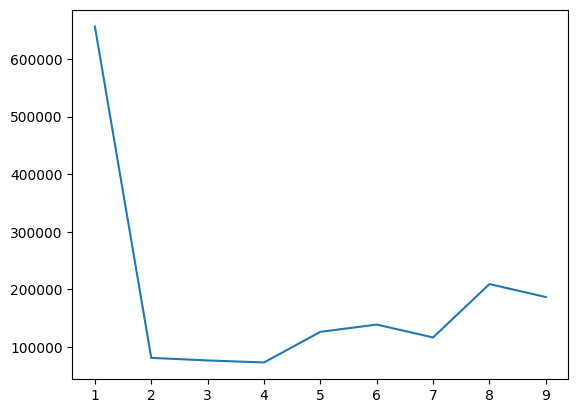

In [35]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_LSTM) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_LSTM)
plt.show()

In [36]:
history_ppl_RNN = []

# Callback actualizado con el nuevo `MemoryEfficientPplCallback`
ppl_callback = MemoryEfficientPplCallback(
    val_data=tokenized_sentences_val,   # Datos de validación (secuencias tokenizadas)
    max_context_size=max_context_size,  # Tamaño máximo de la secuencia (ajustar según el contexto de tu tarea)
    history_ppl=history_ppl_RNN,       # Historia de la perplejidad
    model_name='model_RNN_word.keras',      # Nombre del modelo a guardar cuando la perplejidad mejore
    patience=5,                         # Número de épocas de paciencia para el early stopping
    batch_size=256                       # Tamaño de lote para el procesamiento por lotes
)

# Entrenar el modelo con el callback optimizado
hist = model_RNN.fit(
    X, y,                               # Datos de entrenamiento
    epochs=20,                          # Número de épocas
    batch_size=256,                      # Tamaño de lote para el entrenamiento
    callbacks=[ppl_callback]            # El nuevo callback optimizado
)

Epoch 1/20
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.4973
 mean perplexity: 263676.0078622343 

Saved new model! How model_RNN.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 136s 182ms/step - loss: 4.4961
Epoch 2/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 2.9438
 mean perplexity: 256764.02063318467 

Saved new model! How model_RNN.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 115s 151ms/step - loss: 2.9436
Epoch 3/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.5826
 mean perplexity: 251898.87880164513 

Saved new model! How model_RNN.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 147s 158ms/step - loss: 2.5823
Epoch 4/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 2.2624
 mean perplexity: 257766.10645360703 

711/711 ━━━━━━━━━━━━━━━━━━━━ 145s 163ms/step - loss: 2.2623
Epoch 5/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 1.9989
 mean perplexity: 224475.70451117336 

Saved new model! How model_RNN.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 143s 165ms/step - loss: 1.9988
Epoch 6/20
710/711

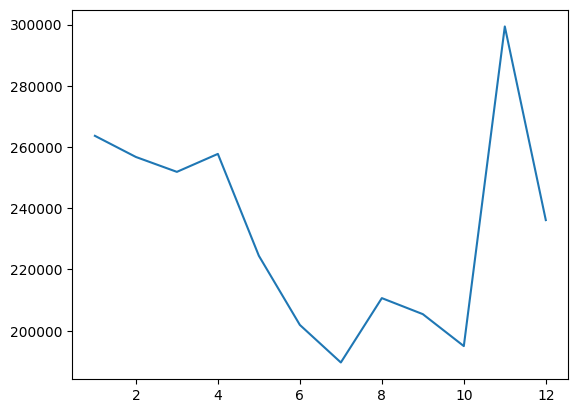

In [37]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_RNN) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_RNN)
plt.show()

In [62]:
history_ppl_GRU = []

# Callback actualizado con el nuevo `MemoryEfficientPplCallback`
ppl_callback = MemoryEfficientPplCallback(
    val_data=tokenized_sentences_val,   # Datos de validación (secuencias tokenizadas)
    max_context_size=max_context_size,  # Tamaño máximo de la secuencia (ajustar según el contexto de tu tarea)
    history_ppl=history_ppl_GRU,       # Historia de la perplejidad
    model_name='model_GRU_word.keras',      # Nombre del modelo a guardar cuando la perplejidad mejore
    patience=5,                         # Número de épocas de paciencia para el early stopping
    batch_size=256                     # Tamaño de lote para el procesamiento por lotes
)

# Entrenar el modelo con el callback optimizado
hist = model_GRU.fit(
    X, y,                               # Datos de entrenamiento
    epochs=20,                          # Número de épocas
    batch_size=256,                      # Tamaño de lote para el entrenamiento
    callbacks=[ppl_callback]            # El nuevo callback optimizado
)

Epoch 1/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 4.5123
 mean perplexity: 172991.53238919517 

Saved new model! How model_GRU.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 117s 162ms/step - loss: 4.5101
Epoch 2/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 3.1230
 mean perplexity: 238542.85492769475 

711/711 ━━━━━━━━━━━━━━━━━━━━ 142s 162ms/step - loss: 3.1228
Epoch 3/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 2.9247
 mean perplexity: 267232.8265492481 

711/711 ━━━━━━━━━━━━━━━━━━━━ 141s 161ms/step - loss: 2.9246
Epoch 4/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.7728
 mean perplexity: 316572.96782775136 

711/711 ━━━━━━━━━━━━━━━━━━━━ 114s 161ms/step - loss: 2.7727
Epoch 5/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.6652
 mean perplexity: 299787.8488128532 

711/711 ━━━━━━━━━━━━━━━━━━━━ 141s 159ms/step - loss: 2.6651
Epoch 6/20
710/711 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 2.5777
 mean perplexity: 338538.1363561581 

Stopping training...
711

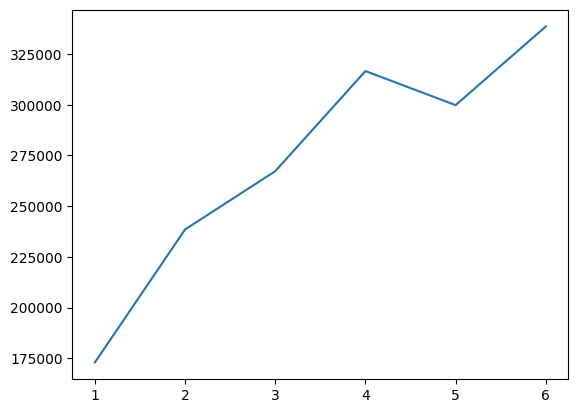

In [63]:
# Entrenamiento
epoch_count = range(1, len(history_ppl_GRU) + 1)
sns.lineplot(x=epoch_count,  y=history_ppl_GRU)
plt.show()

### Validaciones

In [64]:
#carga de los modelos
model_RNN = keras.models.load_model('model_RNN_word.keras')
model_LSTM = keras.models.load_model('model_LSTM_word.keras')
model_GRU = keras.models.load_model('model_GRU_word.keras')

In [65]:
texto_inicial = "Capitán"
print(f'SimpleRNN: { model_response(texto_inicial, "SimpleRNN") }')
print(f'LSTM: {model_response(texto_inicial, "LSTM")}')
print(f'GRU: {model_response(texto_inicial, "GRU")}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
SimpleRNN: Capitán nemo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
LSTM: Capitán y
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
GRU: Capitán de


Debido a que solo contamos con una sola palabra no se puede determinar si los modelos tuvieron o no una buena predicción. Si bien se utilizo la palabra "Capitán" en busqueda de la palabra "Nemo", los resultados de los 3 modelos son validos a priori.

In [66]:
input_text='el capitán Nemo observaba con atención'

generate_seq(model_RNN, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'el capitán Nemo observaba con atención la biblioteca con una especie'

In [67]:
generate_seq(model_LSTM, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'el capitán Nemo observaba con atención que que el nautilus y'

In [68]:
generate_seq(model_GRU, tok, input_text, max_length=max_context_size, n_words=5)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


'el capitán Nemo observaba con atención de la que la que'

Como se puede observar, el único modelo que mantuvo coherencia en la secuencia de palabras fue SimpleRNN, esto nos podría estar diciendo que los modelos LSTM y GRU estan siendo demaciado complejos para el dataset con el que se cuenta. O bien los datos utilizados no tienen la calidad suficiente para el armado de un buen modelo.

In [81]:
# predicción con beam search en modo determinista
texto_input = "el capitán Nemo observaba con atención"
print(f"SimpleRNN: {decode(beam_search(model_RNN,num_beams=15,num_words=7,input=texto_input,temp=1,mode='det')[0])}")
print(f'LSTM: {decode(beam_search(model_LSTM,num_beams=15,num_words=7,input=texto_input,temp=1,mode="det")[0])}')
print(f'GRU: {decode(beam_search(model_GRU,num_beams=15,num_words=7,input=texto_input,temp=1,mode="det")[0])}')

SimpleRNN: ['el capitán nemo observaba con atención los océanos pegasos volantes de hocico alargado']
LSTM: ['el capitán nemo observaba con atención que pies en la superficie de la']
GRU: ['el capitán nemo observaba con atención de la de la que de la']


In [79]:
# predicción con beam search en modo est
texto_input = "el capitán Nemo"
print(f"SimpleRNN, temp=3: {decode(beam_search(model_RNN,num_beams=5,num_words=5,input=texto_input,temp=5,mode='sto')[0])}")
print(f'LSTM, temp=3: {decode(beam_search(model_LSTM,num_beams=5,num_words=5,input=texto_input,temp=5,mode="sto")[0])}')
print(f'GRU, temp=3: {decode(beam_search(model_GRU,num_beams=5,num_words=5,input=texto_input,temp=5,mode="sto")[0])}')

SimpleRNN, temp=3: ['el capitán nemo horade tierras olas movimiento infligirnos']
LSTM, temp=3: ['el capitán nemo vivificante supe inspiran orientó impulsa']
GRU, temp=3: ['el capitán nemo ¡ohé empleó que con reptiles']


### Conclusion

Los modelos entrenados utilizando SimpleRNN, LSTM y GRU presentaron comportamientos distintos en cuanto a la evolución de la perplejidad, lo que sugiere que cada arquitectura reaccionó de manera diferente a los datos y al proceso de entrenamiento.

En el caso del LSTM, se observó una mejora significativa en las primeras etapas, con una disminución rápida de la perplejidad. Sin embargo, tras este progreso inicial, el modelo comenzó a deteriorarse, lo que provocó un aumento sostenido en la perplejidad y, eventualmente, la activación del early stopping. Este comportamiento puede estar relacionado con problemas de sobreajuste, donde el modelo, tras aprender rápidamente patrones iniciales, se volvió demasiado específico a los datos de entrenamiento, perdiendo capacidad de generalización.

Por otro lado, el modelo SimpleRNN mostró una curva de perplejidad con mucho ruido y sin una tendencia clara. Esto puede deberse a la naturaleza de su arquitectura, que tiende a tener dificultades para capturar dependencias a largo plazo en secuencias largas, lo que provoca inestabilidad en el entrenamiento. La falta de una tendencia definida sugiere que el modelo no fue capaz de aprender patrones robustos de los datos, lo cual puede indicar que la arquitectura es insuficiente para esta tarea en particular o que se necesitarían más ajustes en los hiperparámetros.

En cuanto al GRU, la perplejidad fue más baja durante la primera época, lo que indica un buen inicio en la capacidad de predicción del modelo. Sin embargo, este comportamiento no se mantuvo, y la perplejidad empeoró significativamente en las épocas siguientes. Esto podría sugerir que el modelo capturó patrones superficiales rápidamente, pero que su capacidad de refinamiento y aprendizaje profundo a lo largo del entrenamiento fue limitada. Es posible que este problema esté relacionado con un ajuste subóptimo de hiperparámetros o con un tamaño de lote inadecuado.

#### Factores Contribuyentes

Este comportamiento divergente entre las arquitecturas puede estar relacionado con varios factores clave:

* Calidad de los Datos: Si los datos de entrenamiento contienen ruido o no son suficientemente representativos, todos los modelos tendrán dificultades para generalizar. Esto puede haber afectado especialmente al SimpleRNN, que es más sensible a secuencias con ruido.

* Optimización: La selección de hiperparámetros, como la tasa de aprendizaje o el optimizador utilizado, puede haber favorecido o perjudicado a diferentes arquitecturas. Por ejemplo, una tasa de aprendizaje demasiado alta podría haber causado el deterioro del rendimiento en el LSTM y GRU después de las primeras épocas.

* Arquitectura: El tamaño del embedding podría no haber sido adecuado para capturar los matices de los datos. El tamaño del batch también juega un papel crucial, ya que lotes demasiado pequeños o grandes pueden afectar la estabilidad del entrenamiento y la capacidad de generalización. La cantidad de capas y la complejidad de los modelos pueden haber llevado al sobreajuste, especialmente en el caso del LSTM, que mostró un patrón típico de aprender rápido y luego sobreajustar.